In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example


class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())    
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

torch.Size([1, 18])
torch.Size([1, 128])
torch.Size([1, 18])
torch.Size([1, 128])
Greek


5000 5.0 0.6028 Xydis / Greek CORRECT
10000 10.0 0.0040 Shalenkov / Russian CORRECT
15000 15.0 0.1111 Milionis / Greek CORRECT
20000 20.0 0.0373 Paitakes / Greek CORRECT
25000 25.0 0.1874 Lefevre / French CORRECT
30000 30.0 0.2196 Naomhan / Irish CORRECT
35000 35.0 0.4271 Meadhra / Irish CORRECT
40000 40.0 0.6378 Soucek / Czech CORRECT
45000 45.0 0.4712 Antar / Arabic CORRECT
50000 50.0 1.6568 Chong / Korean WRONG (Chinese)
55000 55.00000000000001 0.0566 Trinh / Vietnamese CORRECT
60000 60.0 3.7556 Mazza / Portuguese WRONG (Italian)
65000 65.0 0.1898 Yardley / English CORRECT
70000 70.0 1.1569 Suaird / Irish CORRECT
75000 75.0 0.1098 Dinh / Vietnamese CORRECT
80000 80.0 0.5417 Murray / Scottish CORRECT
85000 85.0 3.6161 Altham / Arabic WRONG (English)
90000 90.0 0.6412 Ho / Vietnamese CORRECT
95000 95.0 0.2525 Henderson / Scottish CORRECT
100000 100.0 0.0464 Macdonald / Scottish CORRECT


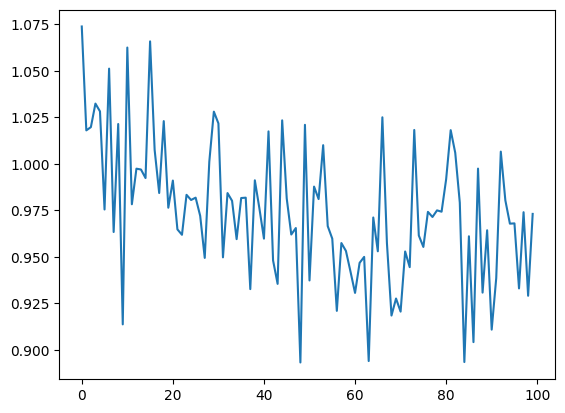

In [6]:
criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
        
plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)